In [1]:
from scipy import signal

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
def preprocess_accel_(csv):

    x_gyro=np.asarray(csv['x-axis (g)'])
    y_gyro=np.asarray(csv['y-axis (g)'])
    z_gyro=np.asarray(csv['z-axis (g)'])
    
    #        y=excel['y-axis(g)']
    #        z=excel['z-axis(g)']
    xyz_gyro=np.transpose(np.array(list(zip(x_gyro,y_gyro,z_gyro))))

    ##############



    def butter_lowpass(cutoff, nyq_freq, order=1):
        normal_cutoff = float(cutoff) / nyq_freq
        b, a = signal.butter(order, normal_cutoff, btype='lowpass')
        #print(b,a)
        return b, a

    def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=1):
        b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
        y = signal.filtfilt(b, a, data)
        return y


    # Filter signal x, result stored to y: 
    cutoff_frequency = 0.3
    sample_rate=25
    #filtered_a = butter_lowpass_filter(a, cutoff_frequency, sample_rate/2)

    # Difference acts as a special high-pass from a reversed butterworth filter. 
    #diff = np.array(a)-np.array(filtered_a)
    ###############################

    x_gyro_filtered=butter_lowpass_filter(x_gyro, cutoff_frequency, sample_rate/2)
    y_gyro_filtered=butter_lowpass_filter(y_gyro, cutoff_frequency, sample_rate/2)
    z_gyro_filtered=butter_lowpass_filter(z_gyro, cutoff_frequency, sample_rate/2) 

    xyz_gyro_filtered=np.transpose(np.array(list(zip(x_gyro_filtered,y_gyro_filtered,z_gyro_filtered))))

    x_gyro_diff= np.array(x_gyro)-np.array(x_gyro_filtered)
    y_gyro_diff= np.array(y_gyro)-np.array(y_gyro_filtered)
    z_gyro_diff= np.array(z_gyro)-np.array(z_gyro_filtered)

    xyz_gyro_diff=np.transpose(np.array(list(zip(x_gyro_diff,y_gyro_diff,z_gyro_diff))))


    
    xyz=np.vstack((xyz_gyro_filtered,xyz_gyro_diff))


    ###standardize
    #xyz_scaled=np.zeros((xyz.shape[0],xyz.shape[1]))
    xyztrans=np.transpose(xyz)
    scaler = StandardScaler()
    scaler.fit(xyztrans)
    #for i in range(xyz.shape[0]):
    #    xyz_scaled[i]=scaler.transform(xyz[i])
    xyz_scaled=np.transpose(scaler.transform(xyztrans))
    return xyz
def preprocess_gyro_(csv):


    x_gyro=np.asarray(csv['x-axis (deg/s)'])
    y_gyro=np.asarray(csv['y-axis (deg/s)'])
    z_gyro=np.asarray(csv['z-axis (deg/s)'])
    #        y=excel['y-axis(g)']
    #        z=excel['z-axis(g)']
    def butter_lowpass(cutoff, nyq_freq, order=4):
        normal_cutoff = float(cutoff) / nyq_freq
        b, a = signal.butter(order, normal_cutoff, btype='lowpass')
        return b, a
    xyz=(np.array(list(zip(x_gyro,y_gyro,z_gyro))))
    
    xyz_ = np.transpose(xyz)
    
    scaler = StandardScaler()
    scaler.fit(xyz)
    #for i in range(xyz.shape[0]):
    #    xyz_scaled[i]=scaler.transform(xyz[i])
    xyz_scaled=np.transpose(np.transpose(scaler.transform(xyz)))
    return xyz_

In [6]:
import sys,os
import pandas as pd
#from leven import levenshtein       
import numpy as np
#import librosa
from sklearn.cluster import dbscan
roota = "/home/govind/OneDrive/" # change with one drive location

test_set= ['KD','KazukiOsawa']
valid_set= ['Arko Dutt']

activities_set = ['Biking',
 'Brushing',
 'ClimbingUp',
 'ClimibingDown',
 'CombHair',
 'Crunches',
 'CyclingIndoor',
 'Drinking',
 'Dumbbell',
 'Eating',
 
 
 'Jogging',
 
 'Lunges',
 'PushUp',
 'SitUp',
 'Sprinting',
 'Squats',
 'Typing',
 'UnwornSensor',
 'Walking',
 'WeightLifting']
test_data=[]
test_labels=[]
train_data=[]
train_labels =[]
valid_data=[]
valid_labels=[]
window_len=64
n_channels=9
allowed= ["Eating","Walking","UnwornSensor","ClimbingDown","Typing","Biking","Drinking", \
          "Brushing","Combhair","Pushup","Jogging","Dumbbell"]
allowed_val =["False_positive","Walking"]
data_appended=np.zeros((n_channels,1))
index1 =np.array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 11., 13., 14., 15.,
       16., 17., 20., 21., 22., 23.]).astype(int).tolist()
for root, dirs, files in os.walk(roota, topdown = False):
    
       subject_name= root.split("/")[-1]
       
       for name in dirs:
          
          if name in activities_set:  
            
              #print(os.path.join(root, name),"exre")
              files_num=0
              for root1, dirs1, files1 in os.walk(os.path.join(root, name), topdown = False):
                  
                        
                        for filename in files1:
                              flag=0
                              if filename.endswith('.csv') and 'Accelerometer' in filename:
                                   
                                   
                                   data=pd.read_csv(os.path.join(root,name,filename))
                                   files_num+=1
                                   if len(data)>15:
                                       preprocessed_data_accel =preprocess_accel_(data) 
                                       
                                   prefix=filename.split('Accelerometer')[0]
                                   for cc in sorted(os.listdir(os.path.join(root,name))):
                                     if prefix in cc and 'Gyroscope' in cc:
                                        flag=1
                                        
                                        filename=cc
                                
                                        data=pd.read_csv(os.path.join(root,name,filename))

                                        if len(data)>15:
                                           preprocessed_data_gyro =preprocess_gyro_(data) 
                                           
                                           flag=1
                                   
                              
                              if flag:
                                if preprocessed_data_accel.shape[1]<=preprocessed_data_gyro.shape[1] :
                                    data_temp= np.concatenate((preprocessed_data_gyro[:,:preprocessed_data_accel.shape[1]],preprocessed_data_accel),axis=0)#,dat_ambient[np.newaxis,:preprocessed_data_accel.shape[1]],dat_pressure[np.newaxis,:preprocessed_data_accel.shape[1]]),axis=0)
                                    #y=np.reshape(data_temp,-1,order='F')

                                    data_appended= np.concatenate((data_appended,data_temp),axis=1)
                                    #print(data_temp.shape)
                                    y=np.reshape(data_temp,-1,order='F')
                                    ### assume series length is window_len samples and n_channels channels for inital use
                                    z= y[:int(np.floor(y.shape[0]//(window_len*n_channels))*window_len*n_channels)]
                                    z=z.reshape(-1,window_len,n_channels) 
                                    data_processed1=np.transpose(z,(0,2,1))
                                    y=y[(n_channels*(window_len//2)):] # change here for overlap percentage /2 is 50% /4 is 25%
                                    z= y[:int(np.floor(y.shape[0]//(window_len*n_channels))*window_len*n_channels)]
                                    z=z.reshape(-1,window_len,n_channels) 
                                    data_processed2=np.transpose(z,(0,2,1))
                                    #print( (os.path.join(root1,name2)))
                                    
                                    #label= sorted(dict_exp_people.keys()).index(name2)
                                    data_=np.concatenate((data_processed1,data_processed2),axis=0)
                                    #print(data_.shape)
                                    scaler = StandardScaler()
                                    labels= np.zeros(data_.shape[0])
#                                     if name=="Walking":
#                                                     labels[:]=2
#                                                     print(subject_name)
                                    #perm_lis=list( np.random.permutation(data_.shape[0]))
                                    
                                    #print(data_.shape,labels.shape)
                                    
                                    labels[:]=activities_set.index(name)
                                    if subject_name in test_set:
                                         
                                            
                                            print(subject_name, name,data_.shape[0],labels.shape,labels.mean())


                                            test_data.append(data_)
                                            test_labels.append(labels)
                                    elif subject_name in valid_set:
                                         
                                            
                                            print(subject_name, name,data_.shape[0],labels.shape,labels.mean())


                                            valid_data.append(data_)
                                            valid_labels.append(labels)
                                    else :
                                        train_data.append(data_)
                                        train_labels.append(labels)


KazukiOsawa UnwornSensor 298 (298,) 17.0
KazukiOsawa ClimbingUp 275 (275,) 2.0
KazukiOsawa ClimibingDown 211 (211,) 3.0
KazukiOsawa Jogging 285 (285,) 10.0
KazukiOsawa Typing 376 (376,) 16.0
KazukiOsawa Lunges 45 (45,) 11.0
KazukiOsawa WeightLifting 34 (34,) 19.0
KazukiOsawa Sprinting 40 (40,) 14.0
KazukiOsawa CyclingIndoor 302 (302,) 6.0
KazukiOsawa Crunches 44 (44,) 5.0
KazukiOsawa Dumbbell 293 (293,) 8.0
KazukiOsawa Walking 293 (293,) 18.0
KazukiOsawa PushUp 24 (24,) 12.0
KazukiOsawa CombHair 239 (239,) 4.0
KazukiOsawa SitUp 273 (273,) 13.0
KazukiOsawa Drinking 39 (39,) 7.0
KazukiOsawa Squats 281 (281,) 15.0
KazukiOsawa Brushing 323 (323,) 1.0
KazukiOsawa Eating 284 (284,) 9.0
KD UnwornSensor 275 (275,) 17.0
KD ClimbingUp 272 (272,) 2.0
KD ClimibingDown 274 (274,) 3.0
KD Jogging 271 (271,) 10.0
KD Typing 272 (272,) 16.0
KD CyclingIndoor 272 (272,) 6.0
KD Walking 271 (271,) 18.0
KD CombHair 272 (272,) 4.0
KD Drinking 11 (11,) 7.0
KD Biking 272 (272,) 0.0
KD Brushing 288 (288,) 1.0
Ar

In [8]:
#print(test_labels,subject_name)
import numpy as np
import scipy
print(np.concatenate(test_labels,axis=0).sum(),np.concatenate(test_data,axis=0).shape)
print(np.concatenate(train_labels,axis=0).shape,np.concatenate(train_data,axis=0).shape)
train_labels1= np.concatenate(train_labels,axis=0)
val_labels1= np.concatenate(valid_labels,axis=0)
test_labels1= np.concatenate(test_labels,axis=0)
#print(np.sum(train_labels1),(test_labels))

import pandas as pd
dft=pd.DataFrame(train_labels1.tolist(),columns=["labels"])

for i in range(20):
    dft['labels']=dft['labels'].replace(float(i),activities_set[i]) 
print(dft['labels'].value_counts())

59692.0 (6709, 9, 64)
(21387,) (21387, 9, 64)
Walking          3029
Eating           2495
Typing           2287
UnwornSensor     1378
Jogging          1217
Biking           1167
CyclingIndoor    1019
ClimbingUp        974
CombHair          964
Lunges            921
WeightLifting     893
SitUp             805
Crunches          722
Brushing          650
Squats            637
Sprinting         618
ClimibingDown     582
PushUp            435
Dumbbell          382
Drinking          212
Name: labels, dtype: int64


In [ ]:

np.histogram(train_labels1,bins=np.arange(24))

In [9]:
import sys,os
import pandas as pd
    
import numpy as np
#import librosa

from sklearn.cluster import dbscan

#roota = "/DL2-Target1/govind/OneDrive/"
roota = "/home/govind/OneDrive/"

test_set=['KD',"gaurav"]
valid_set =['suprajit_1']
window_len=64
n_channels=9
#data_appended=np.zeros((n_channels,1))
dict_people_exp= {}
dict_exp_time={}
dict_exp_people={}
flag2=0
count=0
llb=0
for root, dirs, files in os.walk(roota, topdown = False):
#    for name in files:
#       print(os.path.join(root, name))
       #print(root,dirs)
       if dirs:
            
           #print(dirs,'dirs',root)
           subject_name= root.split("/")[-1]
           for name in dirs:
             # if 'govind' in name:
                  #print(os.path.join(root, name),'top')
                #print(name,'exercise')
                              
                              if name=='Falling':
                                    print(subject_name,"subject")



                                    flag=0

                                    for filename in sorted(os.listdir(os.path.join(root,name))):

                                       flag=0
                                       if filename.endswith('.csv') and 'Accelerometer' in filename:

                                           flag=1
                                           data=pd.read_csv(os.path.join(root,name,filename))

                                       #print(data.columns)
                                       if len(data)>15:
                                           preprocessed_data_accel =preprocess_accel_(data) 

                                           prefix=filename.split('Accelerometer')[0]
                                           for cc in sorted(os.listdir(os.path.join(root,name))):
                                             if prefix in cc and 'Gyroscope' in cc:

                                                #print(prefix)
                                                filename=cc
                                                #print(filename)
                                                data1=pd.read_csv(os.path.join(root,name,filename))
                                                #print(data.columns)
                                                #print(data1.keys(),flag)
                                                if len(data1)>15:
                                                   files_num+=1
                                                   preprocessed_data_gyro =preprocess_gyro_(data1) 
                                                   flag=flag+1
                                       #print(flag,'flag',files_num)
                                       if flag==2:
                                        #print(preprocessed_data_accel.shape[1],preprocessed_data_gyro.shape[1])    
                                        if preprocessed_data_accel.shape[1]<=preprocessed_data_gyro.shape[1] :
                                            count+=1
                                            data_temp= np.concatenate((preprocessed_data_gyro[:,:preprocessed_data_accel.shape[1]],preprocessed_data_accel),axis=0)#,dat_ambient[np.newaxis,:preprocessed_data_accel.shape[1]],dat_pressure[np.newaxis,:preprocessed_data_accel.shape[1]]),axis=0)
                                            #y=np.reshape(data_temp,-1,order='F')

                                            data_appended= np.concatenate((data_appended,data_temp),axis=1)
                                            #print(data_appended.shape,data_temp.shape)

                                            if data_temp.shape[1]<window_len:
                                                #print(data_temp.shape)
                                                data_temp= np.concatenate((np.tile(data_temp[:,0]
                                                                                   [:,np.newaxis],(1,window_len-data_temp.shape[1])),data_temp)
                                                                          ,axis=1)

                                            y=np.reshape(data_temp,-1,order='F')

                                            ### assume series length is window_len samples and n_channels channels for inital use
                                            temp_num=int(np.floor(y.shape[0]//(window_len*n_channels))*window_len*n_channels)
                                            #print(temp_num,"inde")
                                            z= y[y.shape[0]-int(np.floor(y.shape[0]//(window_len*n_channels))*window_len*n_channels):]
                                            z=z.reshape(-1,window_len,n_channels) 
                                            data_processed1=np.transpose(z,(0,2,1))
                                            #print(data_processed1.shape)
    #                                         y=y[(n_channels*(window_len//2)):] # change here for overlap percentage /2 is 50% /4 is 25%
    #                                         z= y[:int(np.floor(y.shape[0]//(window_len*n_channels))*window_len*n_channels)]
    #                                         z=z.reshape(-1,window_len,n_channels) 
    #                                         data_processed2=np.transpose(z,(0,2,1))
                                            #print( (os.path.join(root1,name2)))

                                            #label= sorted(dict_exp_people.keys()).index(name2)
                                            #data_=np.concatenate((data_processed1,data_processed2),axis=0)
                                            #scaler = StandardScaler()
                                            #print(data_processed1.shape[0],"no:of data_snippets" )
                                            labels= np.zeros(1)
                                            labels[:]=1 #activities_set.index("Falling")

                                            if subject_name in test_set:                                    
                                                test_data.append(data_processed1[-1][np.newaxis,:,:])
                                                test_labels.append(labels)
                                                print(llb,filename)
                                                llb+=1
                                            elif subject_name in valid_set:
                                                valid_data.append(data_processed1[-1][np.newaxis,:,:])
                                                valid_labels.append(labels)
                                            else :
                                                train_data.append(data_processed1[-1][np.newaxis,:,:])
                                                train_labels.append(labels)
                                    #print(files_num,"files")        
                                    print(count)        

          

shitala subject
21
darayus_1 subject
34
Darayus Patel subject
51
gaurav subject
0 fallgau1_MetaWear_2019-11-11T17.38.33.478_EAF014A034EC_Gyroscope_25.000Hz_1.3.6.csv
1 fallgau2_MetaWear_2019-11-11T17.39.21.531_EAF014A034EC_Gyroscope_25.000Hz_1.3.6.csv
2 fallgau5_MetaWear_2019-11-11T17.41.46.023_EAF014A034EC_Gyroscope_25.000Hz_1.3.6.csv
3 fallgau7_MetaWear_2019-11-11T17.44.39.580_EAF014A034EC_Gyroscope_50.000Hz_1.3.6.csv
55
suprajit_1 subject
66
Ahmed Zaky subject
85
KazukiOsawa subject
104
govind_1 subject
117
KD subject
4 KDfor1_Ahmed_2019-11-11T17.41.49.282_F447460F942B_Gyroscope_25.000Hz_1.3.6.csv
5 KDfor2_Ahmed_2019-11-11T17.42.24.470_F447460F942B_Gyroscope_25.000Hz_1.3.6.csv
6 KDfor3_Ahmed_2019-11-11T17.43.24.519_F447460F942B_Gyroscope_25.000Hz_1.3.6.csv
7 KDfor4_Ahmed_2019-11-11T17.44.10.334_F447460F942B_Gyroscope_25.000Hz_1.3.6.csv
8 KDfor5_Ahmed_2019-11-11T17.44.45.778_F447460F942B_Gyroscope_25.000Hz_1.3.6.csv
9 KDinno1_Ahmed_2019-11-11T17.45.39.523_F447460F942B_Gyroscope_25.00

In [48]:
print(data_processed1[-1].shape)
print(data1.shape,data.shape,cc,prefix)
x_gyro=np.asarray(data['x-axis (g)'])
y_gyro=np.asarray(data['y-axis (g)'])
z_gyro=np.asarray(data['z-axis (g)'])

#        y=excel['y-axis(g)']
#        z=excel['z-axis(g)'] 
xyz_gyro=np.vstack((x_gyro,y_gyro,z_gyro))
np.savetxt('data_raw_accel.txt',xyz_gyro)  
x_gyro=np.asarray(data1['x-axis (deg/s)'])
y_gyro=np.asarray(data1['y-axis (deg/s)'])
z_gyro=np.asarray(data1['z-axis (deg/s)'])
xyz_gyro=np.vstack((x_gyro,y_gyro,z_gyro))
np.savetxt('data_raw_gyro.txt',xyz_gyro)  
np.savetxt("preprocessed_gyro.txt",preprocessed_data_gyro)
np.savetxt("preprocessed_accel.txt",preprocessed_data_accel)


(6, 64)
(171, 6) (117, 6) darayus_twist3_MetaWear1_2020-01-31T20.11.54.459_EFFC0CE06F0C_Accelerometer_25.000Hz.csv darayus_twist3_MetaWear1_2020-01-31T20.11.54.459_EFFC0CE06F0C_


In [8]:
from scipy.stats import mode
import tensorflow as tf
test_labels


[array([], dtype=float64),
 array([], dtype=float64),
 array([0.]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([], dtype=float64),
 array([0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),


[71.43524911 60.61765604 75.07813242  0.65226739  0.73344189  0.65460851] [-0.75013719 -0.0438054  -0.33871264 -0.09064646 -0.06198356  0.33541542]
indata_z: 128.000000



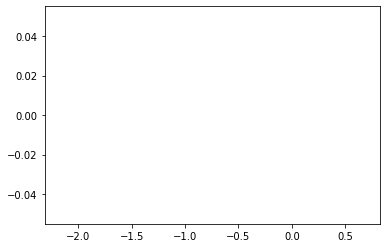

In [50]:
import matplotlib.pyplot as plt
data_out=scaler.transform(np.transpose(data_processed1[-1]))
np.savetxt('data_after_standardization_falling.txt',data_out)
#print(np.max(data_out))
hist, bin_edges = np.histogram(data_out.reshape(-1))
#print(hist)
plt.hist(hist,bin_edges-1)
print(np.sqrt(scaler.var_),scaler.mean_)
input_max=2
input_min=-2
bits = 8
bits_n = 2**bits - 1
Si = (input_max-input_min) / bits_n
indata_q = np.round((data_out- input_min) / Si)
indata_z = np.round(-input_min / Si)
print('indata_z: %f\n' % indata_z)
indata_int = indata_q - indata_z
indata_int = np.clip(indata_int.astype(np.int32),-127,128)
np.savetxt('data_after_standardization_and_quantizatioin_falling.txt',indata_int)

In [ ]:
~/GAN-manifold-regularization-master/HAR_ICASP

In [36]:
from scipy.stats import mode
import tensorflow as tf
#tf.enable_eager_execution()
scaler = StandardScaler()
scaler.fit(np.transpose(data_appended))
def scaled(x):
    for i in range(x.shape[0]):
        x[i]=np.transpose(scaler.transform(np.transpose(x[i])))
    return x

test_arr= np.concatenate(test_data,axis=0).astype(np.float32)
test_labels1= np.concatenate(test_labels)
test_len= test_arr.shape[0]

unique=list(np.unique(test_labels1))
print(unique,"unique",test_labels1[-31:])
ind_random= np.random.permutation(test_len)
# test_arr=test_arr[ind_random]
# test_labels1=test_labels1[ind_random]
val_arr= np.concatenate(valid_data,axis=0).astype(np.float32)
val_labels1= np.concatenate(valid_labels)
val_len= val_arr.shape[0]

train_arr=np.concatenate(train_data,axis=0).astype(np.float32)

        
train_labels1=np.concatenate(train_labels)
ind=np.array([])
ind1 = np.array([])

ind=ind.astype(int)
ind1=ind1.astype(int)
# # a,b=np.histogram(test_labels1,bins=range(22))
# # c,d =np.histogram(train_labels1,bins=range(22))
# # print(a,'\n',b)
# # print(c,d)
ind_random= np.random.permutation(train_arr.shape[0])
train_arr= train_arr[ind_random]
train_labels1=train_labels1[ind_random]

# test_labels1= test_labels1[ind1]
# test_arr= test_arr[ind1]

#print(np.unique(train_labels1))
frame_length= 16
frame_step=4
train_arr =scaled(train_arr)
test_arr= scaled(test_arr)
val_arr= scaled(val_arr)

# fft_train =tf.signal.stft(    train_arr,    frame_length,    frame_step,    fft_length=None,    window_fn=tf.signal.hann_window,
#     pad_end=True,    name='stft'
# )
# fft_test=tf.signal.stft(
#     test_arr,
#     frame_length,
#     frame_step,
#     fft_length=None,
#     window_fn=tf.signal.hann_window,
#     pad_end=True,
#     name='stft2'
# )

print(np.unique(train_labels1),(test_labels1[-39:]))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0] unique [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 7. 7. 7. 7.
 7. 7. 7. 7. 7. 7. 7.]
(21814, 9, 64) (6945, 9, 64)
[ 0.  1.  2.  3.  4.  5.  6.  8.  9. 11. 13. 15. 16. 17. 18. 19. 20. 21.] [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [74]:
val_labels1

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [37]:
savename = './HAR_falling_9channels_22activities'
np.savez(savename,X_test=test_arr,Y_test=test_labels1,X_train=train_arr,\
         Y_train=train_labels1,X_val=val_arr,Y_val=val_labels1)

In [517]:
import random
def balanced_batch_generator(x, y, batch_size, categorical=True):
    """A generator for creating balanced batched.
    This generator loops over its data indefinitely and yields balanced,
    shuffled batches.
    Args:
    x (numpy.ndarray): Samples (inputs). Must have the same length as `y`.
    y (numpy.ndarray): Labels (targets). Must be a binary class matrix (i.e.,
        shape `(num_samples, num_classes)`). You can use `keras.utils.to_categorical`
        to convert a class vector to a binary class matrix.
    batch_size (int): Batch size.
    categorical (bool, optional): If true, generates binary class matrices
        (i.e., shape `(num_samples, num_classes)`) for batch labels (targets).
        Otherwise, generates class vectors (i.e., shape `(num_samples, )`).
        Defaults to `True`.
    Returns a generator yielding batches as tuples `(inputs, targets)` that can
        be directly used with Keras.
    """
    if x.shape[0] != y.shape[0]:
        raise ValueError('Args `x` and `y` must have the same length.')
    if len(y.shape) != 2:
        raise ValueError(
            'Arg `y` must have a shape of (num_samples, num_classes). ' +
            'You can use `keras.utils.to_categorical` to convert a class vector ' +
            'to a binary class matrix.'
        )
    if batch_size < 1:
        raise ValueError('Arg `batch_size` must be a positive integer.')
    num_samples = y.shape[0]
    num_classes = y.shape[1]
    batch_x_shape = (batch_size, *x.shape[1:])
    batch_y_shape = (batch_size, num_classes) if categorical else (batch_size, )
    indexes = [0 for _ in range(num_classes)]
    print(indexes)
    samples = [[] for _ in range(num_classes)]
    for i in range(num_samples):
        samples[np.argmax(y[i])].append(x[i])
    while True:
        batch_x = np.ndarray(shape=batch_x_shape, dtype=x.dtype)
        batch_y = np.zeros(shape=batch_y_shape, dtype=y.dtype)
        for i in range(batch_size):
            random_class = random.randrange(num_classes)
            current_index = indexes[random_class]
            #print(random_class)
            indexes[random_class] = (current_index + 1) % len(samples[random_class])
            if current_index == 0:
                random.shuffle(samples[random_class])
            batch_x[i] = samples[random_class][current_index]
            if categorical:
                batch_y[i][random_class] = 1
            else:
                batch_y[i] = random_class
        #batch_y=batch_y[:,1]
        yield (batch_x, batch_y)

In [258]:
from sklearn.model_selection import train_test_split
dat=np.load(savename)
train_arr=dat["X_train"]
test_arr= dat["X_test"]
test_labels1= dat["Y_test"]
train_labels1 =dat["Y_train"]
print(np.unique(train_labels1),np.unique(test_labels1))
#X_train, X_val, y_train, y_val = train_test_split(train_arr[:,:,:,np.newaxis],tf.keras.utils.to_categorical(train_labels1), test_size=0.01, random_state=42)
print(np.sum(y_val[:,0]),y_val.shape)
print(np.sum(y_train[:,0]),y_train.shape)
batch_size=64
#y_val= y_val[:,1]
batch_generator = balanced_batch_generator(X_train,y_train, batch_size, categorical=True)
val_generator = balanced_batch_generator(X_val,y_val, batch_size, categorical=True)
for xx,yy in batch_generator:
    print(np.mean(yy),yy.shape)
    break
print(y_val.shape)

[0. 1.] [0. 1.]
121.0 (122, 2)
11893.0 (12044, 2)
[0, 0]
0.5 (64, 2)
(122, 2)


In [95]:
savename = './HAR_falling_all_activities_19.npz'
np.savez(savename,X_test=test_arr,Y_test=test_labels1,X_train=train_arr,Y_train=train_labels1)